In [83]:
import pandas as pd 
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture as GMM
from matplotlib import pyplot as plt, cm as cm, mlab as mlab
import seaborn as sns; sns.set()
import progressbar as pb
import time 
import math
from sklearn.decomposition import PCA, FastICA


In [97]:
# read csv/excel data files 
pnas_data1 = pd.read_csv('/home/jaeweon/research/data/pnas_data1.csv')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [98]:
# format data 

# extract 9 Complexity Characteristic variables 
features = ['PolPop', 'PolTerr', 'CapPop', 'levels', 'government','infrastr', 'writing', 'texts', 'money']

# take subset of original data table with 9 CCs and change it into numpy array 
data_mat = pnas_data1.loc[:, features].values
scaled = StandardScaler().fit_transform(data_mat)

In [13]:
# class for progressbar
class progress_timer:

    def __init__(self, n_iter, description="Something"):
        self.n_iter = n_iter
        self.iter = 0
        self.description = description + ': '
        self.timer = None
        self.initialize()

    def initialize(self):
        #initialize timer
        widgets = [self.description, pb.Percentage(), ' ',   
                   pb.Bar(marker=pb.RotatingMarker()), ' ', pb.ETA()]
        self.timer = pb.ProgressBar(widgets=widgets, maxval=self.n_iter).start()

    def update(self, q=1):
        #update timer
        self.timer.update(self.iter)
        self.iter += q

    def finish(self):
        #end timer
        self.timer.finish()

In [14]:
# angle between vectors and various measurements for errors 

def angle(vec1, vec2):
    """
    Given two vectors, compute the angle between the vectors
    """
    assert vec1.shape == vec2.shape
    
    cos_vec = np.inner(vec1, vec2)/(np.linalg.norm(vec1)*np.linalg.norm(vec2))
    angle = math.acos(cos_vec)
    in_deg = math.degrees(angle)
    if in_deg >= 90:
        return (180-in_deg)
    return in_deg

def angle_error(ang1, ang2):
    """
    Given two angles, compute the relative error
    """
    if ang1 >= 90 and ang2 < 90:
        return abs((180-ang1)-ang2)/(180-ang1)
    elif ang1 < 90 and ang2 >= 90:
        return abs(ang1-(180-ang2))/(ang1)
    elif ang1 >= 90 and ang2 >= 90:
        return abs((180-ang1)-(180-ang2))/(180-ang1)
    else:
        return abs(ang1-ang2)/ang1

def vec_error(original, bst):
    """
    Given two n-dim vectors, one from the original and one from bootstrapping, compute the relative error
    between these two vectors
    """
    assert original.shape == bst.shape 
    
    return np.linalg.norm(original-bst)/np.linalg.norm(original)

def error(val1, val2):
    """
    Given two values, compute the relative error
    """
    return abs(val1-val2)/val1


In [71]:
#eigenvalues and eigenvectors for covariance matrix. Determine which of the two components they belong to by 
#the weights of the gaussians

def eig(mat):
    """
    Given a list of two matrices, compute the largest eigenvalues' proportion over sum of all eigenvalues as well 
    as the corresponding eigenvectors
    """
    eig_val1, eig_vec1 = np.linalg.eig(mat[0])
    eig_val2, eig_vec2 = np.linalg.eig(mat[1])
    
    assert eig_vec1.shape == eig_vec2.shape
    assert len(eig_val1) == len(eig_val2)
    
    # proportion of largest eigenvalue with respect to each component
    val1 = max(eig_val1)/sum(eig_val1)
    val2 = max(eig_val2)/sum(eig_val2)
    
    # eigenvector corresponding to the largest eigenvalue with respect to each component
    vec1 = eig_vec1[:,np.argmax(eig_val1)]
    vec2 = eig_vec2[:,np.argmax(eig_val2)]
    
    assert vec1.shape == vec2.shape
    
    return val1, val2, vec1, vec2

def dist(vec1, vec2):
    """
    Euclidean distance between two vectors
    """
    return np.linalg.norm(vec1-vec2)

def mahalanobis(vec, mean, cov):
    """
    Compute the mahalanobis distance of the given vector, vec
    """
    subtracted = np.subtract(vec, mean)
    return math.sqrt(np.matmul(np.matmul(subtracted.T, np.linalg.inv(cov)),subtracted))

def weight_set(means, weights, bstr_means, cov_mat, bstr=False):
    """
    Given gmm model, set the component with larger weight to be the first component and the component with
    smaller weight to be the second component
    """
    
    val1, val2, vec1, vec2 = eig(cov_mat) #eigenvalues and eigenvecotrs for covariance matrices
    
    # designate the larger component to be the component1 and the smaller component the component2 
    
    if bstr: 
        if weights[0] > weights[1]:
            mean1 = means[0]
            mean2 = means[1]
        else:
            mean1 = means[1]
            mean2 = means[0]

        if mahalanobis(bstr_means[0], mean1, cov_mat[0]) < mahalanobis(bstr_means[1], mean1, cov_mat[1]):
            return val1, val2, vec1, vec2
        else:
            return val2, val1, vec2, vec1
    else:
        if weights[0] > weights[1]:
            return val1, val2, vec1, vec2
        else:
            return val2, val1, vec2, vec1


In [89]:
def svd(data):
    """
    perform singular value decomposition on the given data matrix
    """
    #center the data
    mean = np.mean(data, axis=0)
    data -= mean
    
    P, D, Q = np.linalg.svd(data, full_matrices=False)
    
    return P, D, Q
P, D, Q = svd(scaled)
print(Q.T[:,0])

[ 0.35184449  0.32197153  0.33691204  0.34112479  0.33297665  0.33286962
  0.32848139  0.34938387  0.3016939 ]


boostrapping: 100% ||                                          | Time:  0:18:05


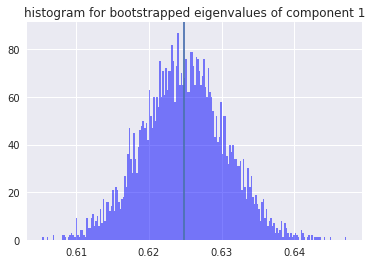

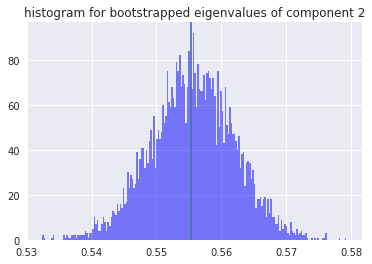

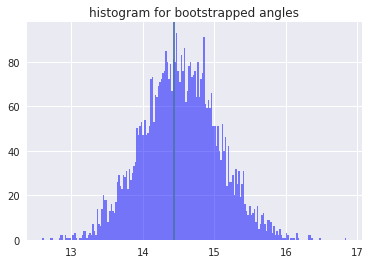

In [100]:
# Fit bivariate Gaussian on the original data and compute confidence intervals, error bars using bootstrapping
pt = progress_timer(description= 'boostrapping', n_iter=5000)

#Gaussian Mixture Model 
#fit GMM
gmm = GMM(n_components=2).fit(data_mat)
orig_means = gmm.means_
orig_cov = gmm.covariances_
orig_weights = gmm.weights_

eigval1, eigval2, eigvec1, eigvec2 = weight_set(orig_means, orig_weights, orig_means, orig_cov)
orig_angle = angle(eigvec1, eigvec2) # angle between the main eigenvectors 

# boostrapping
def bstr(data, n=5000):
    """
    Given data matrix, perform bootstrapping by collecting n samples (default = 5000) and return the 
    error rate for the mean of the data. Assume that the given data matrix is numpy array
    """    
    perc_one = list() # hold proprtion of largest eigenvalues for component 1
    perc_two = list() # hold propotion of largest eigenvalues for component 2
    
    vec_one = list() # hold eigenvectors corresponding to largest eigenvalue for component 1
    vec_two = list() # hold eigenvectors corresponding to largest eigenvalue for component 2
    
    angles = list() # hold angle between main eigenvectors of two Gaussian component
    
    for i in range(n):
        # resample from the original data matrix
        resampled_mat = data[np.random.randint(0, data.shape[0])]
        
        for j in range(data.shape[0]-1):
            data_resample = data[np.random.randint(0, data.shape[0])]
            resampled_mat = np.vstack((resampled_mat, data_resample))
    
        assert resampled_mat.shape == data.shape # check if the resampled matrix has same dimension as data matrix
        
        gmm_resampled = GMM(n_components=2).fit(resampled_mat)
        gmm_weights = gmm_resampled.weights_
        gmm_cov = gmm_resampled.covariances_
        gmm_means = gmm_resampled.means_
        
        eig_val1, eig_val2, eig_vec1, eig_vec2 = weight_set(orig_means, orig_weights, gmm_means, gmm_cov, bstr=True)
        
        perc_one.append(eig_val1)
        perc_two.append(eig_val2)
        vec_one.append(eig_vec1)
        vec_two.append(eig_vec2)
        angles.append(angle(eig_vec1, eig_vec2))
        
        pt.update()
        
    vec_one = np.mean(vec_one, axis=0)
    vec_two = np.mean(vec_two, axis=0)
    
    return perc_one, perc_two, vec_one, vec_two, angles

perc_one, perc_two, vec_one, vec_two, bstr_angle = bstr(data_mat)
pt.finish()

# plot the histogram for eigenvalues and angles
num_bins = 200
itera = [perc_one, perc_two, bstr_angle]
for i in range(len(itera)):
    n, bins, patches = plt.hist(itera[i], num_bins, facecolor='blue', alpha=0.5)
    if i == 0:
        plt.title('histogram for bootstrapped eigenvalues of component 1')
        plt.axvline(x=eigval1)
    elif i == 1:
        plt.title('histogram for bootstrapped eigenvalues of component 2')
        plt.axvline(x=eigval2)
    else:
        plt.title('histogram for bootstrapped angles')
        plt.axvline(x=orig_angle)
    
    plt.show()
    plt.close()


boostrapping: 100% ||                                          | Time:  0:21:06


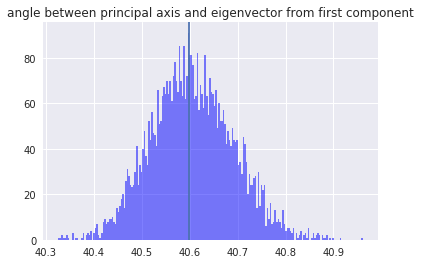

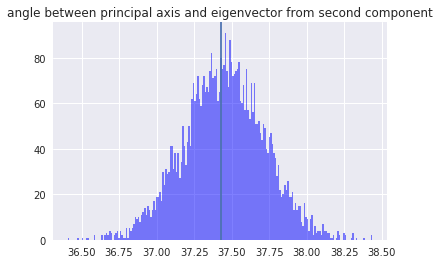

In [128]:
# boostrapping the angle between the principal component and the main eigenvectors of each component
pt = progress_timer(description= 'boostrapping', n_iter=5000)

#fit GMM
gmm = GMM(n_components=2).fit(data_mat)
orig_means = gmm.means_
orig_cov = gmm.covariances_
orig_weights = gmm.weights_

eigval1, eigval2, eigvec1, eigvec2 = weight_set(orig_means, orig_weights, orig_means, orig_cov)
orig_angle1 = angle(eigvec1, Q.T[:,0])
orig_angle2 = angle(eigvec2, Q.T[:,0])

def bstr(pc1, data, n=5000):
    """
    Given data matrix, perform bootstrapping by collecting n samples (default = 5000) and return the 
    error rate for the mean of the data. Assume that the given data matrix is numpy array
    """            
    angle1 = list() # hold angle between main eigenvectors of two Gaussian component
    angle2 = list()
    
    for i in range(n):
        # resample from the original data matrix
        resampled_mat = data[np.random.randint(0, data.shape[0])]
        
        for j in range(data.shape[0]-1):
            data_resample = data[np.random.randint(0, data.shape[0])]
            resampled_mat = np.vstack((resampled_mat, data_resample))
    
        assert resampled_mat.shape == data.shape # check if the resampled matrix has same dimension as data matrix
        
        gmm_resampled = GMM(n_components=2).fit(resampled_mat)
        gmm_weights = gmm_resampled.weights_
        gmm_cov = gmm_resampled.covariances_
        gmm_means = gmm_resampled.means_
        
        eig_val1, eig_val2, eig_vec1, eig_vec2 = weight_set(orig_means, orig_weights, gmm_means, gmm_cov, bstr=True)
        
        angle1.append(angle(eig_vec1, pc1))
        angle2.append(angle(eig_vec2, pc1))
        pt.update()
            
    return angle1, angle2

angle_first, angle_second = bstr(Q.T[:,0], data_mat)
pt.finish()

# plot the histogram for eigenvalues and angles
num_bins = 200

# angle between PC and the first component
n, bins, patches = plt.hist(angle_first, num_bins, facecolor='blue', alpha=0.5)
plt.title('angle between principal axis and eigenvector from first component')
plt.axvline(x=orig_angle1)
plt.show()
plt.close()

# angle between PC and the second component 
n, bins, patches = plt.hist(angle_second, num_bins, facecolor='blue', alpha=0.5)
plt.title('angle between principal axis and eigenvector from second component')
plt.axvline(x=orig_angle2)
plt.show()
plt.close()


boostrapping: 100% ||                                          | Time:  0:01:13


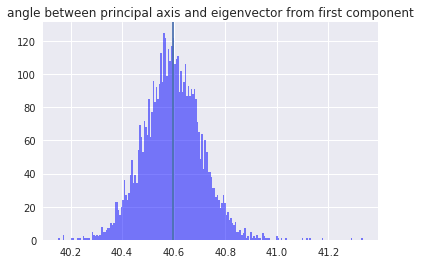

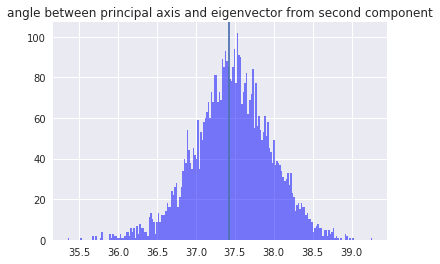

In [127]:
# bootstrap on single, random imputation 
pt = progress_timer(description= 'boostrapping', n_iter=5000)

#fit GMM
gmm = GMM(n_components=2).fit(data_mat)
orig_means = gmm.means_
orig_cov = gmm.covariances_
orig_weights = gmm.weights_

eigval1, eigval2, eigvec1, eigvec2 = weight_set(orig_means, orig_weights, orig_means, orig_cov)
orig_angle1 = angle(eigvec1, Q.T[:,0])
orig_angle2 = angle(eigvec2, Q.T[:,0])

def bstr(pc1, data, n=5000):
    """
    Given data matrix, perform bootstrapping by collecting n samples (default = 5000) and return the 
    error rate for the mean of the data. Assume that the given data matrix is numpy array
    """            
    angle1 = list() # hold angle between the PC and the main eigenvector for component1
    angle2 = list() # hold angle between the PC and the main eigenvector for component2
        
    for i in range(n):
        
        # resample from the original data matrix
        for j in range(414):
            ran_impute = np.random.randint(20)
            
            if j == 0: #first element 
                resampled_mat = data[j+ran_impute*414]
            else:
                resampled_mat = np.vstack((resampled_mat, data[j+ran_impute*414]))
        
        assert len(resampled_mat) == 414 # check if the resampled matrix has same dimension as data matrix
        
        gmm_resampled = GMM(n_components=2).fit(resampled_mat)
        gmm_weights = gmm_resampled.weights_
        gmm_cov = gmm_resampled.covariances_
        gmm_means = gmm_resampled.means_
        
        eig_val1, eig_val2, eig_vec1, eig_vec2 = weight_set(orig_means, orig_weights, gmm_means, gmm_cov, bstr=True)
        
        angle1.append(angle(eig_vec1, pc1))
        angle2.append(angle(eig_vec2, pc1))
        pt.update()
            
    return angle1, angle2

angle_first, angle_second = bstr(Q.T[:,0], data_mat)
pt.finish()

# plot the histogram for eigenvalues and angles
num_bins = 200

# angle between PC and the first component
n, bins, patches = plt.hist(angle_first, num_bins, facecolor='blue', alpha=0.5)
plt.title('angle between principal axis and eigenvector from first component')
plt.axvline(x=orig_angle1)
plt.show()
plt.close()

# angle between PC and the second component 
n, bins, patches = plt.hist(angle_second, num_bins, facecolor='blue', alpha=0.5)
plt.title('angle between principal axis and eigenvector from second component')
plt.axvline(x=orig_angle2)
plt.show()
plt.close()
